In [83]:
import numpy as np
import math
import residuals as r
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True)

In [98]:
# I am defining the weighted standard deviation according to this definition:
# https://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_variance
# I am using the inverse square of the error arrays to define the weights

# factor10 = math.sqrt((25*60)/10.0) 
# factor80 = math.sqrt((25*60)/80.0) 


def weighted_stddev(values, errors):
    '''
    Return the weighted average and standard deviation.

    '''
    weights = 1. / ((errors)**2)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (math.sqrt(variance))

def magnitude(x):
    var = float(x)
    return int(math.floor(math.log10(var)))


def jitter_ratio(psrname, MJDint, condition_lower, condition_upper):
    '''
    Prints the ratio of sigma_dump over sigma_all.
    
    Prints the correlation coefficient too, so we can easily compare here.
    
    Requires residuals in four time resolutions: 80s, 40s, 20s and NT intervals.

    '''
    
    jitter_ratios = OrderedDict()
    for elem in ['80', '40', '20', 'NT']:
    
        #Define sigma_all (or std_all) as entire observation period
        x=r.read_residuals(filename="/nimrod1/eschwab/residuals/%s_resid_%s_%sF8.tmp" %(psrname, MJDint, elem))

        condition = (x.bary_TOA > condition_lower) & (x.bary_TOA < condition_upper)
        Resid_all = x.prefit_sec[condition]
        Errors_all = x.uncertainty[condition]
        std_all = weighted_stddev(Resid_all, Errors_all)

        ##============

        #Define sigma_dump (or std_all) as individual dumps within observation period

        #This isolates the numbers for the different dump times
        rounded = np.round(np.array([x.bary_TOA[condition] - 0.00005]), 4)
        dumptimes=[]
        for i in rounded.tolist()[0]: 
            if i not in dumptimes:
                dumptimes.append(i)

        #This calculates a list of sigma_dump values and averages those
        str_dump_devs=[]
        for i in dumptimes:
            timeindex = (rounded == i)[0]
            Resid = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            single_std_dump = weighted_stddev(Resid, Errors)
            str_dump_devs.append(single_std_dump)

        #to convert str_dump_devs out of scientific notation
        dump_devs=[]
        for i in str_dump_devs:
            dump_devs.append('{0:.20f}'.format(i))

        #prints the magnitude of each sigma_dump in a list and finds average magnitude
        magarray=[]
        for i in dump_devs:
            magarray.append(magnitude(i))
        averagemag = round(np.mean(magarray))

        arg=averagemag+1.5
        makemask = np.ma.masked_where(np.array(magarray) > arg, np.array(magarray))

        std_dump=np.mean(str_dump_devs)
        masked_std_dump = np.mean(np.ma.masked_where(np.ma.getmask(makemask), str_dump_devs))

        #Setup jitter ratio
        ratio = std_all / std_dump
        masked_ratio = float(std_all / masked_std_dump)
        jitter_ratios[elem] = masked_ratio

        ##============

        #Print out the correlation coefficient also, to allow for easy reference

        #Creating the matrix of the data and transposing it to correct format
        data = []
        data_errors = []
        for i in dumptimes[1:]: #the first set of resids needs to be skipped in J1713, but not sure for all of them?
            timeindex = (rounded == i)[0]
            Resids = Resid_all[timeindex]
            Errors = Errors_all[timeindex]
            data.append(Resids)
            data_errors.append(Errors)

        data = map(list, zip(*data)) #transposing the matrix, supposedly unnecessary if rowvar=0 in corr but gives errors

        #Using the Weighted Correlation Coefficient from wikipedia
        #https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient#Weighted_correlation_coefficient
        # I added weights by creating a weighted value to multiply each data element by
        #The weighted values are normalized by dividing each value by the sum of all weights

        data_weights = 1. / (np.array(data_errors)**2)
        data_weights = map(list, zip(*(data_weights.tolist())))

        #data_weights is a matrix of all the weights

        norm_weights = []
        for i in data_weights:
            norm_weights.append([j/sum(i) for j in i])

        weighted_data = []
        for i,j in zip(data, norm_weights):
            weighted_data.append([a*b for a,b in zip(i,j)])

        #Correlating! 
        corr = np.corrcoef(data)
        weighted_corr = np.corrcoef(weighted_data)

        unique_corrs = []
        #Averaging the correlation
        for i in range(len(corr)):
            unique_corrs.append(corr[i][i+1:]) #because numpy array, double index necessay
        unique_corrs  = [val for sublist in unique_corrs for val in sublist]
        final_coefficient = np.average(unique_corrs)

        unique_weighted_corrs = []
        #Averaging the correlation
        for i in range(len(weighted_corr)):
            unique_weighted_corrs.append(weighted_corr[i][i+1:]) #because numpy array, double index necessay
        unique_weighted_corrs  = [val for sublist in unique_weighted_corrs for val in sublist]
        final_weighted_coefficient = np.average(unique_weighted_corrs)
        
        'J1713+0747, MJD 56380, 80 second subintervals'

        print "%s, MJD %s, %s second subintervals" %(psrname, MJDint, elem)
        print "sigma_all = " + str(std_all)
        print "average sigma_dump = " + str(std_dump)
        print "jitter ratio = " + str(ratio) 
        print "masked jitter ratio = " + str(masked_ratio) 
        print "correlation coefficient = " + str(final_coefficient)
        print "weighted correlation coefficient = " + str(final_weighted_coefficient)
        print '##========'
        print ' '

    #Now plotting the jitter ratios for all four time scrunches
    plt.figure(figsize=(17,4))
    plt.plot(range(len(jitter_ratios)), jitter_ratios.values())
    plt.scatter(range(len(jitter_ratios)), jitter_ratios.values())
    plt.xticks(range(len(jitter_ratios)), jitter_ratios.keys())
    plt.xlabel('Subinterval Duration', fontsize='14')
    plt.ylabel('Jitter Ratio ($\sigma_A$ / $\sigma_D$)', fontsize='14')
    plt.gca().invert_xaxis()

In [34]:
jitter_ratio("/nimrod1/eschwab/residuals/J1713+0747_resid_56380_80F8.tmp",
            56380.35, 56380.367, 'J1713+0747, MJD 56380, 80 second subintervals')

J1713+0747, MJD 56380, 80 second subintervals
sigma_all = 2.44415585816e-07
average sigma_dump = 2.49624000145e-08
jitter ratio = 9.79134961678
masked jitter ratio = 9.79134961678
correlation coefficient = 0.975310619846
weighted correlation coefficient = 0.935093128473


In [6]:
jitter_ratio("/nimrod1/eschwab/residuals/J1713+0747_resid_56380_NTF8.tmp",
            56380.35, 56380.367, 'J1713+0747, MJD 56380, 10 second subintervals')

J1713+0747, MJD 56380, 10 second subintervals
sigma_all = 5.82671845721e-07
average sigma_dump = 7.10113781891e-08
jitter ratio = 8.20533075938
masked jitter ratio = 8.20533075938
correlation coefficient = 0.965601343627
weighted correlation coefficient = 0.72062523975


In [7]:
jitter_ratio("/nimrod1/eschwab/residuals/J1713+0747_resid_56201_80F8.tmp",
            56201.85, 56201.872, 'J1713+0747, MJD 56201, 80 second subintervals')

J1713+0747, MJD 56201, 80 second subintervals
sigma_all = 1.73501235065e-07
average sigma_dump = 5.08948679605e-08
jitter ratio = 3.40901238215
masked jitter ratio = 3.40901238215
correlation coefficient = 0.893879830465
weighted correlation coefficient = 0.862007717236


In [8]:
jitter_ratio("/nimrod1/eschwab/residuals/J1713+0747_resid_56201_NTF8.tmp",
            56201.85, 56201.872, 'J1713+0747, MJD 56201, 10 second subintervals')

J1713+0747, MJD 56201, 10 second subintervals
sigma_all = 5.43224438005e-07
average sigma_dump = 8.13611454109e-08
jitter ratio = 6.67670588045
masked jitter ratio = 6.67670588045
correlation coefficient = 0.916150377776
weighted correlation coefficient = 0.895444174152


In [9]:
jitter_ratio("/nimrod1/eschwab/residuals/B1937+21_resid_56465_80F8.tmp",
            56465.3, 56465.32, 'B1937+21, MJD 56465, 80 second subintervals')

B1937+21, MJD 56465, 80 second subintervals
sigma_all = 4.68059107539e-08
average sigma_dump = 4.44210286622e-08
jitter ratio = 1.05368813293
masked jitter ratio = 1.05368813293
correlation coefficient = 0.0816201709277
weighted correlation coefficient = 0.506229938622


In [10]:
jitter_ratio("/nimrod1/eschwab/residuals/B1937+21_resid_56465_NTF8.tmp",
            56465.3, 56465.32, 'B1937+21, MJD 56465, 10 second subintervals')

B1937+21, MJD 56465, 10 second subintervals
sigma_all = 7.05138954322e-08
average sigma_dump = 4.92378535069e-08
jitter ratio = 1.43210742163
masked jitter ratio = 1.43210742163
correlation coefficient = 0.771068051713
weighted correlation coefficient = 0.652272051319


In [11]:
jitter_ratio("/nimrod1/eschwab/residuals/J1022+1001_resid_57208_80F8.tmp",
            57208.778, 57208.79, 'J1022+1001, MJD 57208, 80 second subintervals')

J1022+1001, MJD 57208, 80 second subintervals
sigma_all = 4.6866049668e-05
average sigma_dump = 0.000296708047933
jitter ratio = 0.157953415806
masked jitter ratio = 3.33695161071
correlation coefficient = -0.0908035595199
weighted correlation coefficient = 0.173805858185


In [12]:
jitter_ratio("/nimrod1/eschwab/residuals/J1022+1001_resid_57208_NTF8.tmp",
            57208.778, 57208.79, 'J1022+1001, MJD 57208, 10 second subintervals')

J1022+1001, MJD 57208, 10 second subintervals
sigma_all = 0.000104350827388
average sigma_dump = 0.000345928859937
jitter ratio = 0.301654008881
masked jitter ratio = 2.1828169481
correlation coefficient = -0.270679064499
weighted correlation coefficient = 0.247261000947


In [13]:
jitter_ratio("/nimrod1/eschwab/residuals/J1022+1001_resid_57331_80F8.tmp",
            57331.443, 57331.4595, 'J1022+1001, MJD 57331, 10 second subintervals')

J1022+1001, MJD 57331, 10 second subintervals
sigma_all = 1.65569569649e-06
average sigma_dump = 1.43649632382e-06
jitter ratio = 1.15259306204
masked jitter ratio = 1.15259306204
correlation coefficient = 0.131051206325
weighted correlation coefficient = 0.209338838827


In [14]:
jitter_ratio("/nimrod1/eschwab/residuals/J1022+1001_resid_57331_NTF8.tmp",
            57331.443, 57331.4595, 'J1022+1001, MJD 57331, 10 second subintervals')

J1022+1001, MJD 57331, 10 second subintervals
sigma_all = 1.99889485593e-05
average sigma_dump = 1.28371737411e-05
jitter ratio = 1.55711443675
masked jitter ratio = 2.07273433488
correlation coefficient = 0.0634166037353
weighted correlation coefficient = 0.549554001675


In [15]:
jitter_ratio("/nimrod1/eschwab/residuals/J2317+1439_resid_57273_80F8.tmp",
            57273.196, 57273.217, 'J2317+1439, MJD 57273, 80 second subintervals')

J2317+1439, MJD 57273, 80 second subintervals
sigma_all = 8.63069774192e-05
average sigma_dump = 7.9531672163e-05
jitter ratio = 1.08519002646
masked jitter ratio = 1.08519002646
correlation coefficient = 0.393373284044
weighted correlation coefficient = 0.482656996874


In [16]:
jitter_ratio("/nimrod1/eschwab/residuals/J2317+1439_resid_57273_NTF8.tmp",
            57273.196, 57273.217, 'J2317+1439, MJD 57273, 10 second subintervals')

J2317+1439, MJD 57273, 10 second subintervals
sigma_all = 0.000136392509784
average sigma_dump = 0.000136221578037
jitter ratio = 1.00125480668
masked jitter ratio = 1.00125480668
correlation coefficient = -0.0165572422927
weighted correlation coefficient = 0.0139920273057


In [17]:
jitter_ratio("/nimrod1/eschwab/residuals/J2234+0944_resid_57069_80F8.tmp",
            57069.7, 57069.72, 'J2234+0944, MJD 57069, 80 second subintervals')

J2234+0944, MJD 57069, 80 second subintervals
sigma_all = 3.09374810381e-07
average sigma_dump = 2.54509387228e-07
jitter ratio = 1.21557327905
masked jitter ratio = 1.21557327905
correlation coefficient = 0.244021824527
weighted correlation coefficient = 0.1947853598


In [35]:
jitter_ratio("/nimrod1/eschwab/residuals/J2234+0944_resid_57069_NTF8.tmp",
            57069.7, 57069.72, 'J2234+0944, MJD 57069, 10 second subintervals')

J2234+0944, MJD 57069, 10 second subintervals
sigma_all = 7.79080622293e-07
average sigma_dump = 6.23925410863e-07
jitter ratio = 1.24867589736
masked jitter ratio = 1.24867589736
correlation coefficient = 0.181644203051
weighted correlation coefficient = 0.450330636602


In [53]:
jitter_ratio("/nimrod1/eschwab/residuals/J1944+0907_resid_56627_80F8.tmp",
            56627.77, 56627.805, 'J1944+0907, MJD 56627, 80 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J1944+0907_resid_56627_40F8.tmp",
            56627.77, 56627.805, 'J1944+0907, MJD 56627, 40 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J1944+0907_resid_56627_20F8.tmp",
            56627.77, 56627.805, 'J1944+0907, MJD 56627, 20 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J1944+0907_resid_56627_NTF8.tmp",
            56627.77, 56627.805, 'J1944+0907, MJD 56627, 10 second subintervals')

J1944+0907, MJD 56627, 80 second subintervals
sigma_all = 3.33443949134e-05
average sigma_dump = 3.26905850769e-05
jitter ratio = 1.01999994295
masked jitter ratio = 1.01999994295
correlation coefficient = 0.101973490293
weighted correlation coefficient = 0.0651012926555
##========
J1944+0907, MJD 56627, 40 second subintervals
sigma_all = 3.72123364776e-05
average sigma_dump = 3.21108337561e-05
jitter ratio = 1.1588716992
masked jitter ratio = 1.1588716992
correlation coefficient = 0.204620700727
weighted correlation coefficient = 0.164917193296
##========
J1944+0907, MJD 56627, 20 second subintervals
sigma_all = 4.32509911152e-05
average sigma_dump = 3.4804152858e-05
jitter ratio = 1.24269627512
masked jitter ratio = 1.24269627512
correlation coefficient = -0.0615860267297
weighted correlation coefficient = 0.109056993576
##========


ValueError: math domain error

In [56]:
jitter_ratio("/nimrod1/eschwab/residuals/J2234+0611_resid_56843_80F8.tmp",
            56843.315, 56843.335, 'J2234+0611, MJD 56843, 80 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2234+0611_resid_56843_40F8.tmp",
            56843.315, 56843.335, 'J2234+0611, MJD 56843, 40 second subintervals')
# jitter_ratio("/nimrod1/eschwab/residuals/J2234+0611_resid_56843_20F8.tmp",
#             56843.315, 56843.335, 'J2234+0611, MJD 56843, 20 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2234+0611_resid_56843_NTF8.tmp",
            56843.315, 56843.335, 'J2234+0611, MJD 56843, 10 second subintervals')

J2234+0611, MJD 56843, 80 second subintervals
sigma_all = 1.9013686857e-05
average sigma_dump = 1.60257157749e-05
jitter ratio = 1.18644852586
masked jitter ratio = 1.18644852586
correlation coefficient = 0.0462870874128
weighted correlation coefficient = 0.00693974307886
##========
J2234+0611, MJD 56843, 40 second subintervals
sigma_all = 2.62303421774e-05
average sigma_dump = 2.16977636819e-05
jitter ratio = 1.20889611307
masked jitter ratio = 1.20889611307
correlation coefficient = 0.00861386891935
weighted correlation coefficient = 0.0149010593745
##========
J2234+0611, MJD 56843, 10 second subintervals
sigma_all = 5.2995425714e-05
average sigma_dump = 4.31865330468e-05
jitter ratio = 1.22712850454
masked jitter ratio = 1.22712850454
correlation coefficient = 0.0856885976785
weighted correlation coefficient = 0.192566960826
##========


In [45]:
jitter_ratio("/nimrod1/eschwab/residuals/J2229+2643_resid_57234_80F8.tmp",
            57234.255, 57234.275, 'J2229+2643, MJD 57234, 80 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2229+2643_resid_57234_40F8.tmp",
            57234.255, 57234.275, 'J2229+2643, MJD 57234, 40 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2229+2643_resid_57234_20F8.tmp",
            57234.255, 57234.275, 'J2229+2643, MJD 57234, 20 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2229+2643_resid_57234_NTF8.tmp",
            57234.255, 57234.275, 'J2229+2643, MJD 57234, 10 second subintervals')

J2229+2643, MJD 57234, 80 second subintervals
sigma_all = 7.28480556269e-06
average sigma_dump = 4.20763111572e-06
jitter ratio = 1.73133180223
masked jitter ratio = 1.73133180223
correlation coefficient = 0.072480601191
weighted correlation coefficient = 0.0398812019984
##========
J2229+2643, MJD 57234, 40 second subintervals
sigma_all = 1.17433736297e-05
average sigma_dump = 6.26113887877e-06
jitter ratio = 1.87559705304
masked jitter ratio = 1.87559705304
correlation coefficient = 0.146408939472
weighted correlation coefficient = 0.0872174298955
##========
J2229+2643, MJD 57234, 20 second subintervals
sigma_all = 1.81694011661e-05
average sigma_dump = 1.03109452218e-05
jitter ratio = 1.76214699769
masked jitter ratio = 2.10090971036
correlation coefficient = 0.183361778215
weighted correlation coefficient = 0.0778600236818
##========
J2229+2643, MJD 57234, 10 second subintervals
sigma_all = 2.95101900589e-05
average sigma_dump = 1.782580008e-05
jitter ratio = 1.65547632793
masked ji

In [47]:
jitter_ratio("/nimrod1/eschwab/residuals/J0023+0923_resid_56023_80F8.tmp",
            56023.66, 56023.68, 'J0023+0923, MJD 56023, 80 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J0023+0923_resid_56023_40F8.tmp",
            56023.66, 56023.68, 'J0023+0923, MJD 56023, 40 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J0023+0923_resid_56023_20F8.tmp",
            56023.66, 56023.68, 'J0023+0923, MJD 56023, 20 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J0023+0923_resid_56023_NTF8.tmp",
            56023.66, 56023.68, 'J0023+0923, MJD 56023, 10 second subintervals')

J0023+0923, MJD 56023, 80 second subintervals
sigma_all = 4.94718556922e-07
average sigma_dump = 4.53724114577e-07
jitter ratio = 1.09035103277
masked jitter ratio = 1.09035103277
correlation coefficient = 0.11642325302
weighted correlation coefficient = 0.439244289771
##========
J0023+0923, MJD 56023, 40 second subintervals
sigma_all = 6.8972793334e-07
average sigma_dump = 5.6407222134e-07
jitter ratio = 1.22276529006
masked jitter ratio = 1.22276529006
correlation coefficient = 0.256433971406
weighted correlation coefficient = 0.669546322242
##========
J0023+0923, MJD 56023, 20 second subintervals
sigma_all = 1.03740055025e-06
average sigma_dump = 8.43548580155e-07
jitter ratio = 1.22980534216
masked jitter ratio = 1.22980534216
correlation coefficient = 0.176676622978
weighted correlation coefficient = 0.565660155595
##========
J0023+0923, MJD 56023, 10 second subintervals
sigma_all = 1.03740055025e-06
average sigma_dump = 8.43548580155e-07
jitter ratio = 1.22980534216
masked jitter

In [49]:
jitter_ratio("/nimrod1/eschwab/residuals/J1738+0333_resid_57124_80F8.tmp",
            57124.352, 57124.37, 'J1738+0333, MJD 57124, 80 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J1738+0333_resid_57124_40F8.tmp",
            57124.352, 57124.37, 'J1738+0333, MJD 57124, 40 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J1738+0333_resid_57124_20F8.tmp",
            57124.352, 57124.37, 'J1738+0333, MJD 57124, 20 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J1738+0333_resid_57124_NTF8.tmp",
            57124.352, 57124.37, 'J1738+0333, MJD 57124, 10 second subintervals')

J1738+0333, MJD 57124, 80 second subintervals
sigma_all = 5.51075574083e-07
average sigma_dump = 4.92082321532e-07
jitter ratio = 1.11988492569
masked jitter ratio = 1.11988492569
correlation coefficient = 0.0109126997516
weighted correlation coefficient = 0.295940224352
##========
J1738+0333, MJD 57124, 40 second subintervals
sigma_all = 7.49003924014e-07
average sigma_dump = 6.59139121944e-07
jitter ratio = 1.13633662315
masked jitter ratio = 1.13633662315
correlation coefficient = -0.130122024398
weighted correlation coefficient = 0.112805817829
##========
J1738+0333, MJD 57124, 20 second subintervals
sigma_all = 1.04473079553e-06
average sigma_dump = 9.43471369556e-07
jitter ratio = 1.1073264428
masked jitter ratio = 1.1073264428
correlation coefficient = 0.0634849042457
weighted correlation coefficient = 0.324284912575
##========
J1738+0333, MJD 57124, 10 second subintervals
sigma_all = 6.58498574301e-06
average sigma_dump = 3.11780772905e-06
jitter ratio = 2.11205639195
masked ji

In [50]:
jitter_ratio("/nimrod1/eschwab/residuals/J2214+3000_resid_56739_80F8.tmp",
            56739.63, 56739.66, 'J2214+3000, MJD 56739, 80 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2214+3000_resid_56739_40F8.tmp",
            56739.63, 56739.66, 'J2214+3000, MJD 56739, 40 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2214+3000_resid_56739_20F8.tmp",
            56739.63, 56739.66, 'J2214+3000, MJD 56739, 20 second subintervals')
jitter_ratio("/nimrod1/eschwab/residuals/J2214+3000_resid_56739_NTF8.tmp",
            56739.63, 56739.66, 'J2214+3000, MJD 56739, 10 second subintervals')

J2214+3000, MJD 56739, 80 second subintervals
sigma_all = 3.82246330354e-05
average sigma_dump = 4.33566618257e-05
jitter ratio = 0.881632289613
masked jitter ratio = 0.881632289613
correlation coefficient = 0.669399673152
weighted correlation coefficient = 0.636952781992
##========
J2214+3000, MJD 56739, 40 second subintervals
sigma_all = 4.4848379189e-05
average sigma_dump = 5.49375658654e-05
jitter ratio = 0.816351771006
masked jitter ratio = 0.816351771006
correlation coefficient = 0.173834688661
weighted correlation coefficient = 0.276027040171
##========
J2214+3000, MJD 56739, 20 second subintervals
sigma_all = 7.15166668525e-05
average sigma_dump = 8.43468638058e-05
jitter ratio = 0.847887682192
masked jitter ratio = 0.847887682192
correlation coefficient = 0.0163692452808
weighted correlation coefficient = 0.0217246528229
##========
J2214+3000, MJD 56739, 10 second subintervals
sigma_all = 0.000115268651999
average sigma_dump = 0.000134676667463
jitter ratio = 0.85589177525
mas

In [ ]:
# writing out the correlation code

#first i need to isolate the arrays. There should be 8 in most, but some still have 16.
#(rereduce J1713 and B1937 with updated jitterpipe)

#I'll be isolating the arrays of residuals, they will all be residuals of the same frequency band
#going forward in time

#starting with J1713, even though I'm going to make it divisible by 14 frequency bands.
#usually this will be 8 or 9


#Defining arrays
x=r.read_residuals(filename="/nimrod1/eschwab/residuals/J1713+0747_resid_56380_80F8.tmp")

date = 56380
condition=(x.bary_TOA > 56380.35) & (x.bary_TOA < 56380.367)

TOA=x.bary_TOA[condition]
Resid=x.prefit_sec[condition]
Freq=x.bary_freq[condition]
Error=x.uncertainty[condition]

#Creating a matrix of arrays in the correct order
# Rows of residuals by frequency
# Columns by TOA
rounded = np.round(np.array([x.bary_TOA[condition] - 0.00005]), 4)
dumptimes=[]
for i in rounded.tolist()[0]: 
    if i not in dumptimes:
        dumptimes.append(i)

#Creating the data and transposing it to correct format
data = []
for i in dumptimes[1:]:
    timeindex = (rounded == i)[0]
    Resids = Resid[timeindex]
    data.append(list(Resids))
realdata = map(list, zip(*data))

#Correlating!
corr = np.corrcoef(realdata).tolist()

unique_corrs = []
#Averaging the correlation
for i in range(len(corr))[:-1]:
    unique_corrs.append(corr[i][i+1:]) #because numpy array, double index necessay
unique_corrs  = [val for sublist in unique_corrs for val in sublist]
np.average(unique_corrs)

J2229+2643, MJD 57234, 80 second subintervals
sigma_all = 7.28480556269e-06
average sigma_dump = 4.20763111572e-06
jitter ratio = 1.73133180223
masked jitter ratio = 1.73133180223
correlation coefficient = 0.072480601191
weighted correlation coefficient = 0.0398812019984
##========
 
J2229+2643, MJD 57234, 40 second subintervals
sigma_all = 1.17433736297e-05
average sigma_dump = 6.26113887877e-06
jitter ratio = 1.87559705304
masked jitter ratio = 1.87559705304
correlation coefficient = 0.146408939472
weighted correlation coefficient = 0.0872174298955
##========
 
J2229+2643, MJD 57234, 20 second subintervals
sigma_all = 1.81694011661e-05
average sigma_dump = 1.03109452218e-05
jitter ratio = 1.76214699769
masked jitter ratio = 2.10090971036
correlation coefficient = 0.183361778215
weighted correlation coefficient = 0.0778600236818
##========
 
J2229+2643, MJD 57234, NT second subintervals
sigma_all = 2.95101900589e-05
average sigma_dump = 1.782580008e-05
jitter ratio = 1.65547632793
mas

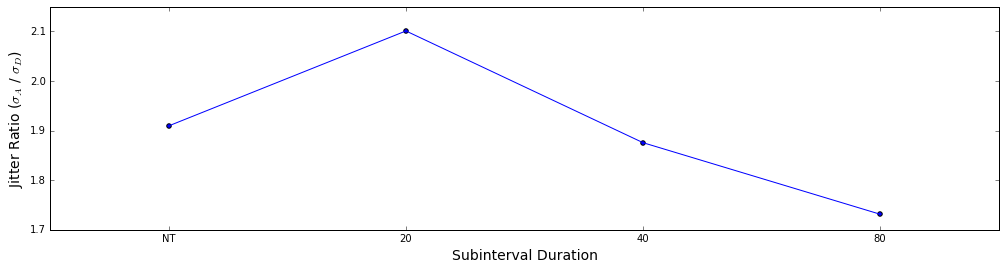

In [99]:
jitter_ratio("J2229+2643", "57234", 57234.255, 57234.275)